<a href="https://colab.research.google.com/github/EmaTran/OB-Air/blob/main/OB%20Airways%20Fuel%20Optimization%20Report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Section 1: Overview

### Problem Statement
  OB Airways, a commercial airline, aims to improve operational efficiency through better fuel management. Currently, flight fuel is planned based on pre-determined estimates, but deviations often occur between planned and actual fuel consumption. These inefficiencies can lead to excess fuel costs, suboptimal payload planning, and environmental impact.

The goal is two-fold:

1.    Conduct a data-driven analysis of fuel consumption across past flights to identify key patterns and inefficiencies.
2.     Build a predictive machine learning model to forecast planned_flight_fuel_kilograms, enabling better planning accuracy and operational decisions.



###Metrics
For Analysis (Fuel Consumption Trends): mean, median, standard deviation & Skewness, correlation matrix.

For Model Evaluation:RMSE, MAE, R².


##Section 2: Analysis

###Data import

Clean the `df_actual_flights` and `df_flight_plan` DataFrames.



In [127]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.stats import skew, kurtosis
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import StandardScaler
import math
import warnings

In [91]:

# Load the Excel file
excel_file = pd.ExcelFile('GDA- OB_DS_PREINTERVIEW_TEST.xlsx')

# Load the relevant sheets into dataframes
df_actual_flights = excel_file.parse('actual_flights')
df_flight_plan = excel_file.parse('flight_plan')

# Display the first few rows of each dataframe to understand their structure
df_actual_flights.head(), df_flight_plan.head()


(  aircraft_id                                 flight_id actual_time_departure  \
 0        4369  9245e5aa23b52b7ed6b7875bb70a596addcff648   2024-03-28 07:47:00   
 1        4369  bf09806fb6e737e177b7767591fdff67e16e488e   2024-02-17 01:58:00   
 2        CB3B  ff3c7a0b68c91351f2d9644722a4b96a74d412a6   2024-08-12 05:54:00   
 3        4369  82f1f852944aa676595c198af4c8cd5247d5a34c   2024-04-30 08:08:00   
 4        BCDF  61408e654ad59c2e4a1dce636d427df85594a6f5   2024-07-10 06:13:00   
 
   actual_time_departure_tz  actual_time_arrival actual_time_arrival_tz  \
 0                   +00:00  2024-03-28 08:50:00                 +00:00   
 1                   +00:00  2024-02-17 13:27:00                 +00:00   
 2                   +00:00  2024-08-12 07:23:00                 +00:00   
 3                   +00:00  2024-04-30 10:10:00                 +00:00   
 4                   +00:00  2024-07-10 08:26:00                 +00:00   
 
    actual_flight_fuel_kilograms  total_aircraft_fligh

In [114]:
# Drop rows where 'flight_id' is missing
df_flight_plan = df_flight_plan[df_flight_plan['flight_id'].notna()].copy()
print("Shape after dropping missing flight_id:", df_flight_plan.shape)

Shape after dropping missing flight_id: (4393, 13)


In [92]:
# Calculate and display the shape of the dataframes
print("Shape of df_actual_flights:", df_actual_flights.shape)
print("Shape of df_flight_plan:", df_flight_plan.shape)

Shape of df_actual_flights: (11685, 14)
Shape of df_flight_plan: (9097, 13)


###Data Exploration

In [93]:
# Examine Data Shape and Types
print("Shape and data types:")
for df_name, df in [ ('df_actual_flights', df_actual_flights), ('df_flight_plan', df_flight_plan)]:
    print(f"\n{df_name}:")
    print(f"Shape: {df.shape}")
    print(f"Data types:\n{df.dtypes}")

# Identify Missing Values
print("\nMissing values:")
for df_name, df in [ ('df_actual_flights', df_actual_flights), ('df_flight_plan', df_flight_plan)]:
    print(f"\n{df_name}:")
    print(df.isnull().sum())

# Descriptive Statistics
print("\nDescriptive Statistics for df_actual_flights:")
display(df_actual_flights.describe(include='all'))

print("\nDescriptive Statistics for df_flight_plan:")
display(df_flight_plan.describe(include='all'))

print("\nFrequency of unique values in categorical columns:")

for col in df_actual_flights.select_dtypes(include=['object']):
    print(f"\nColumn: {col}")
    display(df_actual_flights[col].value_counts())

for col in df_flight_plan.select_dtypes(include=['object']):
    print(f"\nColumn: {col}")
    display(df_flight_plan[col].value_counts())

# Updated skew and kurtosis analysis using correct column names
columns_to_check = ['actual_flight_fuel_kilograms', 'uplifted_fuel_kilograms', 'flight_hours']

print("\nBasic Data Distribution Analysis:")
for col in columns_to_check:
    if col in df_actual_flights.columns:
        print(f"\nColumn: {col}")
        print(f"Skewness: {df_actual_flights[col].skew():.2f}")
        print(f"Kurtosis: {df_actual_flights[col].kurt():.2f}")

Shape and data types:

df_actual_flights:
Shape: (11685, 14)
Data types:
aircraft_id                                        object
flight_id                                          object
actual_time_departure                              object
actual_time_departure_tz                           object
actual_time_arrival                                object
actual_time_arrival_tz                             object
actual_flight_fuel_kilograms                      float64
total_aircraft_flight_cycles                      float64
flight_hours                                      float64
total_aircraft_flight_hours                       float64
uplifted_fuel_kilograms                           float64
fuel_remaining_after_previous_flight_kilograms    float64
departure_airport                                  object
arrival_airport                                    object
dtype: object

df_flight_plan:
Shape: (9097, 13)
Data types:
is_actual                                bool
flight_p

,aircraft_id,flight_id,actual_time_departure,actual_time_departure_tz,actual_time_arrival,actual_time_arrival_tz,actual_flight_fuel_kilograms,total_aircraft_flight_cycles,flight_hours,total_aircraft_flight_hours,uplifted_fuel_kilograms,fuel_remaining_after_previous_flight_kilograms,departure_airport,arrival_airport
count,11685,11685,11685,11685,11685,11685,9519.00000,11682.000000,11683.000000,11682.000000,9525.000000,286.000000,11685,11683
unique,12,11664,11462,1,11449,1,NaN,NaN,NaN,NaN,NaN,NaN,100,101
top,A7BE,61cfc79f376232f7f402b3e011c7bfe492765cf9,2024-08-23 16:39:00,+00:00,2024-02-13 12:40:00,+00:00,NaN,NaN,NaN,NaN,NaN,NaN,AE0A4,AE0A4
freq,1238,2,3,11685,3,11685,NaN,NaN,NaN,NaN,NaN,NaN,2919,2909
mean,NaN,NaN,NaN,NaN,NaN,NaN,8684.15779,15451.826913,2.319361,32448.348258,8770.600525,6203.496503,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,12594.88982,3971.815167,1.887357,16693.427687,13063.879091,4707.227553,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,-50140.00000,7492.000000,0.000000,17511.870000,0.000000,2560.000000,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,4220.00000,12411.250000,1.450000,22136.527500,3117.600000,3785.000000,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,5280.00000,16221.000000,1.850000,24730.240000,5970.400000,6230.000000,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,6180.00000,18168.000000,2.230000,35518.935000,8584.800000,7240.000000,NaN,NaN



Descriptive Statistics for df_flight_plan:


,is_actual,flight_plan_id,planned_flight_fuel_kilograms,flight_id,total_payload_kilograms,aircraft_id,air_distance_miles,estimated_takeoff_weight_kilograms,scheduled_time_departure,scheduled_time_departure_tz,planned_flight_hours,departure_airport,arrival_airport
count,9097,9097,9097.000000,8793,9097.000000,8793,9097.000000,9097.000000,9097,9097,9097.000000,9097,9091
unique,2,9070,NaN,4040,NaN,9,NaN,NaN,3985,1,NaN,51,50
top,False,fffdc0be6a3e1664593bf4d8a255ce3d4e4302d7,NaN,43c280b00db13cc87f1458d5ea751d6d33e5d9f4,NaN,A7BE,NaN,NaN,2024-08-09 06:00:00,+00:00,NaN,AE0A4,AE0A4
freq,4552,2,NaN,8,NaN,1239,NaN,NaN,10,9097,NaN,2536,2691
mean,NaN,NaN,7348.322513,NaN,13097.551061,NaN,975.041552,71790.940640,NaN,NaN,2.279466,NaN,NaN
std,NaN,NaN,9967.314161,NaN,6513.954781,NaN,745.410882,31921.188421,NaN,NaN,1.578524,NaN,NaN
min,NaN,NaN,544.000000,NaN,0.000000,NaN,34.000000,45501.000000,NaN,NaN,0.166667,NaN,NaN
25%,NaN,NaN,4202.000000,NaN,8712.000000,NaN,641.000000,59520.000000,NaN,NaN,1.533333,NaN,NaN
50%,NaN,NaN,5151.000000,NaN,15246.000000,NaN,814.000000,66801.000000,NaN,NaN,1.950000,NaN,NaN
75%,NaN,NaN,5956.500000,NaN,17460.000000,NaN,916.000000,68956.000000,NaN,NaN,2.166667,NaN,NaN



Frequency of unique values in categorical columns:

Column: aircraft_id


,count
aircraft_id,
A7BE,1238
BCDF,1237
CB3B,1217
CCD8,1208
163C,1178
3267,1154
2E09,1150
7BB1,953
BA50,940



Column: flight_id


,count
flight_id,
61cfc79f376232f7f402b3e011c7bfe492765cf9,2
f96b89fe7308af29cf9550eb536afeaa70ce941a,2
49d217e7e47b23433a528f1a01363525c1156913,2
f3c18cba0e3903aa8160fcae9669b7b7c49e0a39,2
ce5253586f4a93238b0bad74b1d84532f6ddfdef,2
...,...
80d2839dc2ba875f211bd66d69bf7b8faded8184,1
91db4c7a7c64d0cfb3b406adea96c41f804ef17f,1
a9d84d3ea557a00d8deb50a367d89ee348d2c158,1



Column: actual_time_departure


,count
actual_time_departure,
2024-08-23 16:39:00,3
2024-06-17 07:54:00,3
2024-07-18 16:55:00,3
2024-08-12 10:52:00,3
2024-05-31 15:35:00,3
...,...
2024-01-04 11:04:00,1
2024-02-02 05:07:00,1
2024-06-08 17:40:00,1



Column: actual_time_departure_tz


,count
actual_time_departure_tz,
+00:00,11685



Column: actual_time_arrival


,count
actual_time_arrival,
2024-02-13 12:40:00,3
2024-03-03 13:00:00,3
2024-01-13 13:57:00,2
2024-01-19 16:44:00,2
2024-01-10 11:52:00,2
...,...
2024-06-02 17:46:00,1
2024-01-19 17:35:00,1
2024-06-23 21:33:00,1



Column: actual_time_arrival_tz


,count
actual_time_arrival_tz,
+00:00,11685



Column: departure_airport


,count
departure_airport,
AE0A4,2919
AD6EA,1521
AD11C,894
A24D9,773
A51F4,750
...,...
A9C48,1
A7DC0,1
AA83F,1



Column: arrival_airport


,count
arrival_airport,
AE0A4,2909
AD6EA,1524
AD11C,893
A24D9,775
A51F4,749
...,...
AA83F,1
A17E5,1
A7DC0,1



Column: flight_plan_id


,count
flight_plan_id,
fffdc0be6a3e1664593bf4d8a255ce3d4e4302d7,2
fffc11bfe6ef0960ec864831d792bf85e8843d7f,2
fff4f092817f7795f5313b33c7e174acf3c361b8,2
fff17257603129e8958de9ad42ccad39f09995ef,2
ffecb455f6735414f0c42f51cb1412b15f1febf4,2
...,...
56d41faa39d36777c2233eec18603633d9ed2527,1
56dd054720f0e088dbaa8032a631c091ccb719c6,1
56f0080a10428fd46cbc35affc926414f6289c11,1



Column: flight_id


,count
flight_id,
43c280b00db13cc87f1458d5ea751d6d33e5d9f4,8
d38d6d1dad30bd6ca377c5fb6988cdefaa161520,8
a0f3c5d404d70b79bce0d7a2812bb5be3faf74de,8
b19dbe84def9d1adbeb92aceffc69e7f7e1ee200,8
5930cad5bf050772c5a0d0f1c41b2c488d1e77c7,8
...,...
151c7c340f91184b3b1c23b2fa33177b83210824,2
2182cd4899da7b2ffff4bb3dd378dbfd0197dd68,2
51f35dd9ef902c276a2b35a05f46a30bd44be68d,2



Column: aircraft_id


,count
aircraft_id,
A7BE,1239
163C,1197
3267,1191
BCDF,1189
2E09,1182
CB3B,1172
7BB1,1019
6CC2,377
4369,227



Column: scheduled_time_departure


,count
scheduled_time_departure,
2024-08-09 06:00:00,10
2024-07-04 13:30:00,8
2024-06-22 20:00:00,8
2024-07-29 07:55:00,8
2024-07-04 18:00:00,8
...,...
2024-06-20 08:50:00,2
2024-06-10 19:10:00,2
2024-07-03 23:55:00,2



Column: scheduled_time_departure_tz


,count
scheduled_time_departure_tz,
+00:00,9097



Column: departure_airport


,count
departure_airport,
AE0A4,2536
AD6EA,1596
A24D9,814
A2095,679
A51F4,650
A6657,410
A2E76,274
AE2B2,271
A45F3,244



Column: arrival_airport


,count
arrival_airport,
AE0A4,2691
AD6EA,1477
A24D9,763
A2095,679
A51F4,673
A6657,424
A2E76,275
AE2B2,261
A45F3,233



Basic Data Distribution Analysis:

Column: actual_flight_fuel_kilograms
Skewness: 3.75
Kurtosis: 13.54

Column: uplifted_fuel_kilograms
Skewness: 3.52
Kurtosis: 12.19

Column: flight_hours
Skewness: 3.46
Kurtosis: 12.89


All three features are slightly right-skewed, meaning longer flights or heavier fuel loads are less common but present.
1. actual_flight_fuel_kilograms
Skewness = 3.75: Highly right-skewed (long tail on the right).
Kurtosis = 13.54: Very peaked with heavy tails, presence of extreme values or outliers.

2. uplifted_fuel_kilograms
Skewness = 3.52, Kurtosis = 12.19: Also right-skewed and leptokurtic (many outliers)
Indicates some flights are filled with unusually high fuel, perhaps long-haul or over-fueled aircraft.
3. flight_hours
Skewness = 3.46, Kurtosis = 12.89: Strong right skew. Most flights are short duration, with a few very long ones (matches the earlier histogram).



###Data Visualization

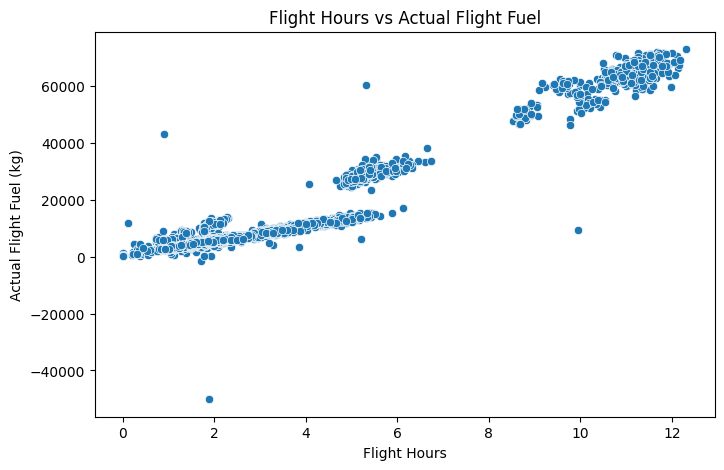

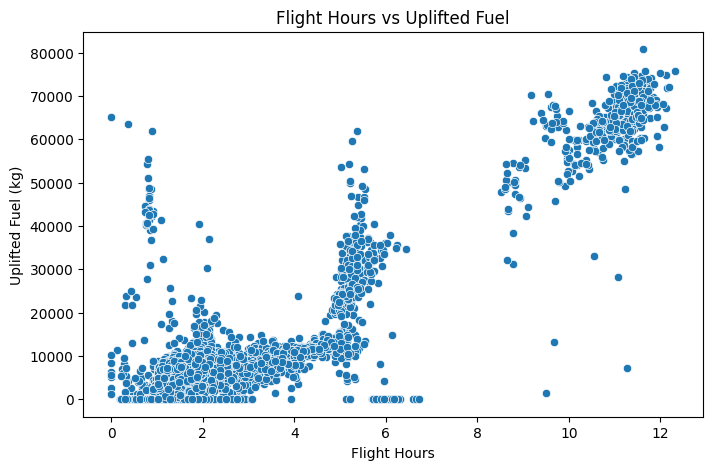

In [94]:
# Flight hours vs actual fuel
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df_actual_flights, x='flight_hours', y='actual_flight_fuel_kilograms')
plt.title("Flight Hours vs Actual Flight Fuel")
plt.xlabel("Flight Hours")
plt.ylabel("Actual Flight Fuel (kg)")
plt.show()

# Flight hours vs uplifted fuel
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df_actual_flights, x='flight_hours', y='uplifted_fuel_kilograms')
plt.title("Flight Hours vs Uplifted Fuel")
plt.xlabel("Flight Hours")
plt.ylabel("Uplifted Fuel (kg)")
plt.show()


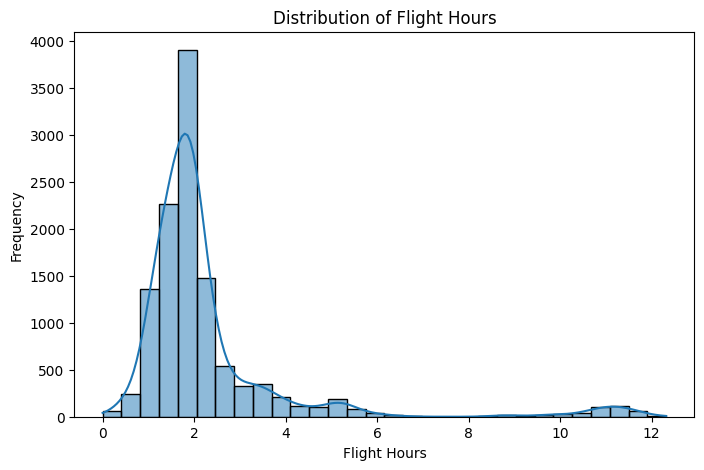

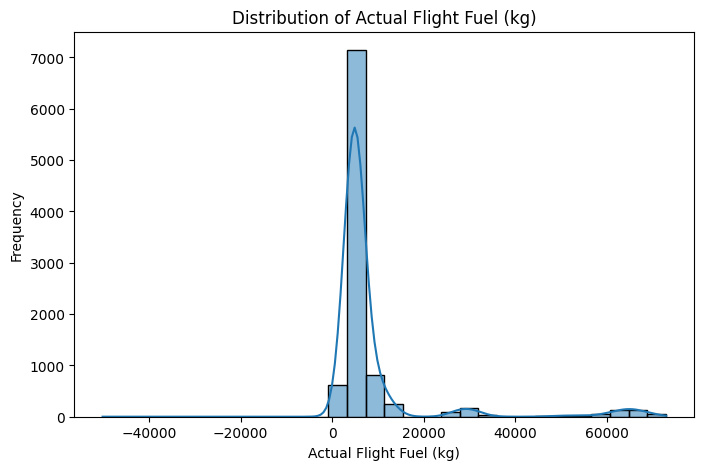

In [95]:
# Distribution of Flight Hours
plt.figure(figsize=(8, 5))
sns.histplot(df_actual_flights['flight_hours'], kde=True, bins=30)
plt.title("Distribution of Flight Hours")
plt.xlabel("Flight Hours")
plt.ylabel("Frequency")
plt.show()

# Distribution of Actual Flight Fuel
plt.figure(figsize=(8, 5))
sns.histplot(df_actual_flights['actual_flight_fuel_kilograms'], kde=True, bins=30)
plt.title("Distribution of Actual Flight Fuel (kg)")
plt.xlabel("Actual Flight Fuel (kg)")
plt.ylabel("Frequency")
plt.show()

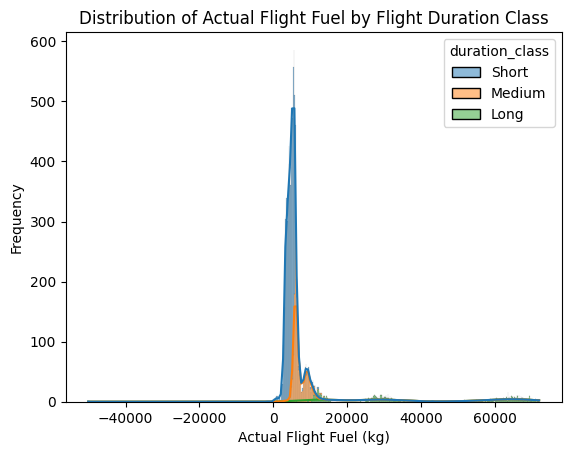

In [96]:
# Create duration classes based on 'flight_hours' in df_actual_flights
# Using fixed bins that are more robust to data filtering
# Define bins that make sense for flight duration, e.g., [0, 2, 5, inf) for Short, Medium, Long
# Let's assume Short is < 2 hours, Medium is 2-5 hours, and Long is > 5 hours
df_actual_flights['duration_class'] = pd.cut(df_actual_flights['flight_hours'], bins=[0, 2, 4, df_actual_flights['flight_hours'].max()], labels=['Short', 'Medium', 'Long'], right=False) # Using right=False to include 0 in the first bin

# Plot the distribution of actual flight fuel, colored by the new duration_class
sns.histplot(data=df_actual_flights, x='actual_flight_fuel_kilograms', hue='duration_class', kde=True, multiple="stack")
plt.title("Distribution of Actual Flight Fuel by Flight Duration Class")
plt.xlabel("Actual Flight Fuel (kg)")
plt.ylabel("Frequency")
plt.show()

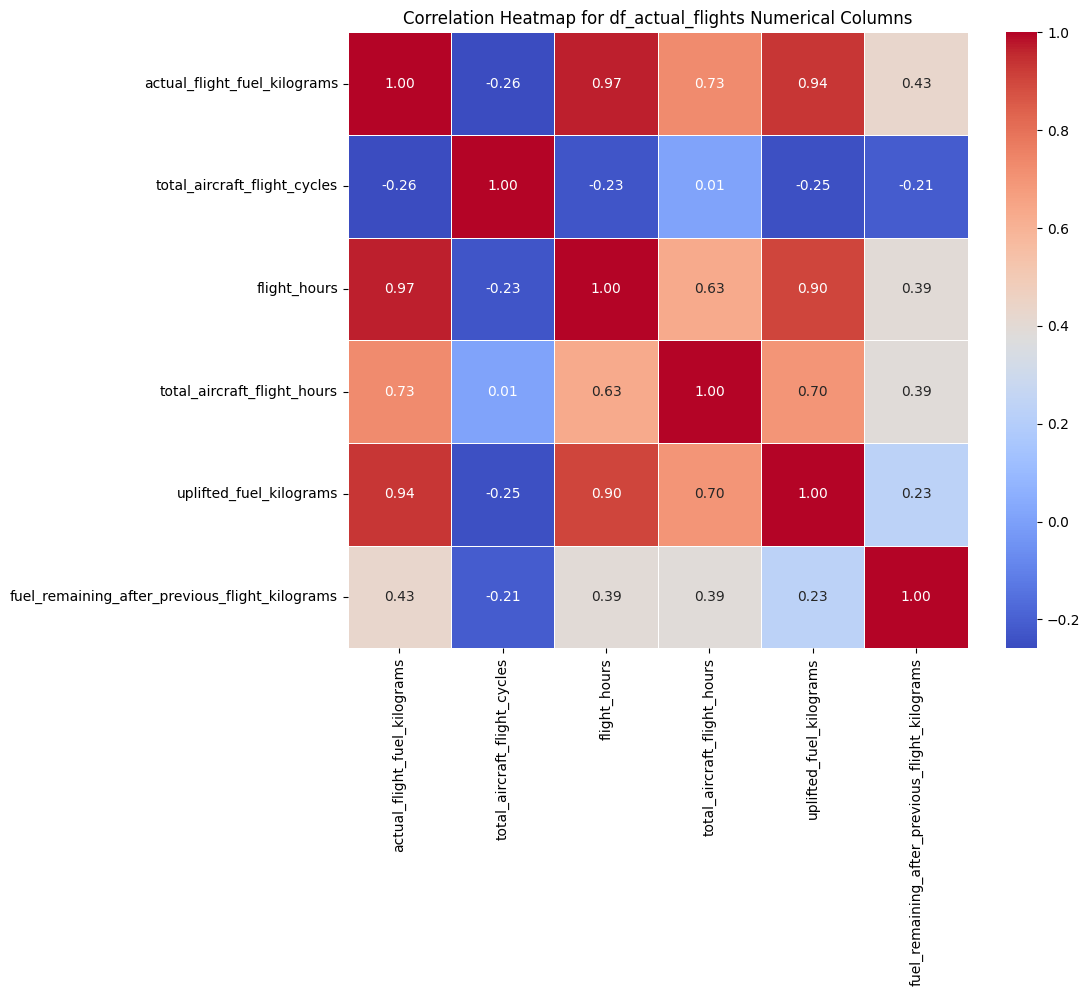

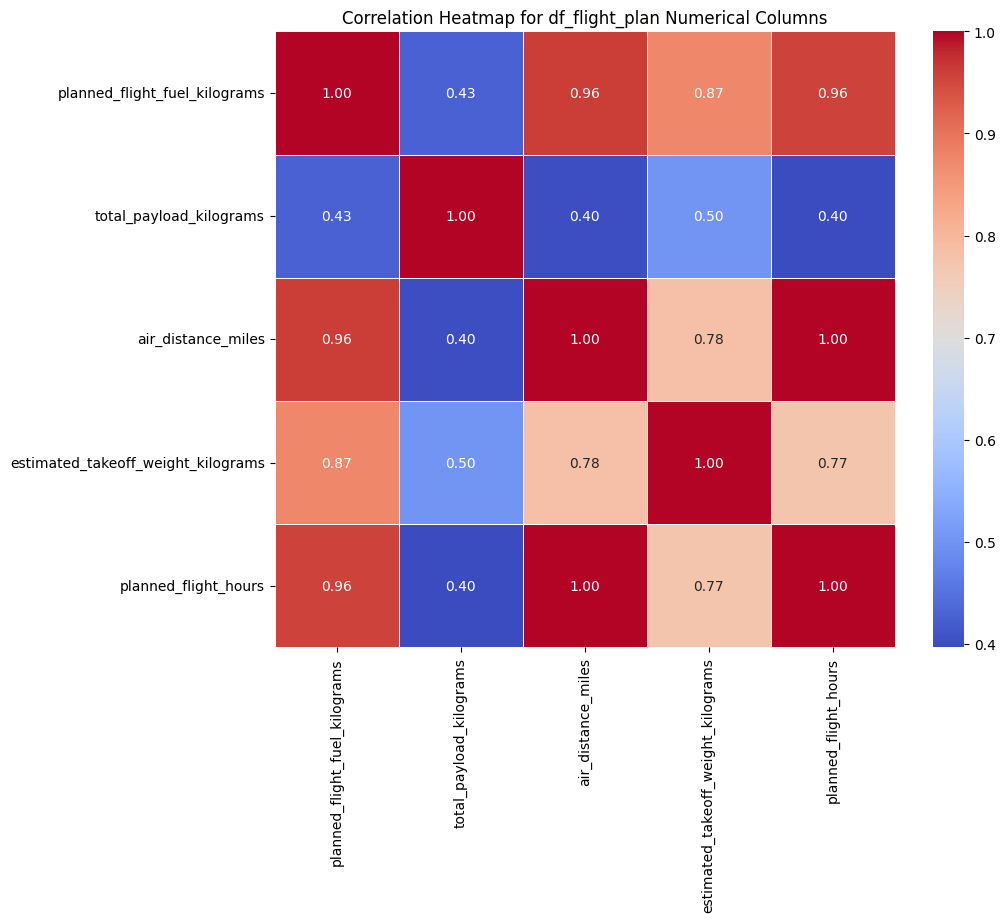

In [97]:
# Select numerical columns for correlation analysis
numerical_cols_actual = df_actual_flights.select_dtypes(include=['number'])
numerical_cols_plan = df_flight_plan.select_dtypes(include=['number'])

# Calculate the correlation matrix for each DataFrame
correlation_matrix_actual = numerical_cols_actual.corr()
correlation_matrix_plan = numerical_cols_plan.corr()

# Plot the correlation heatmap for df_actual_flights
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_actual, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap for df_actual_flights Numerical Columns')
plt.show()

# Plot the correlation heatmap for df_flight_plan
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_plan, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap for df_flight_plan Numerical Columns')
plt.show()

###Insights
**Useful Attributes from actual_flights:   flight_hours,  uplifted_fuel_kilograms,  actual_flight_fuel_kilograms**

**Useful Attributes from flight_plan: air_distance_miles, planned_flight_hours, estimated_takeoff_weight_kilograms**


  Distribution of Actual Flight Fuel (kg) is moderately right-skewed.

  Most flights use 3000 to 6000 kg of fuel.

  That extreme spike at 9000 kg relatively for long -haul flight

####Flight Hours vs Actual Flight Fuel
  Clear linear trends in three separate bands:

* Cluster 1 (0–2 hrs): Low fuel use, typically 0–20,000 kg. Short-haul flights.

* Cluster 2 (2–6 hrs): Moderate fuel use, around 5,000–40,000 kg. Medium-haul routes.

* Cluster 3 (6–8 hrs): Mid-high fuel use, typically 10,000–50,000 kg.

* Cluster 4 (8–12 hrs): High fuel use, ranging 15,000–70,000 kg. Long-haul flights.

* Cluster 5 (>12 hrs): Very high fuel use, 20,000–100,000 kg. Ultra long-haul.

Outliers:

*   A few points with negative fuel values, which are invalid and should be removed.

*   Some low-hour flights with very high actual fuel it possibly data entry errors.


#### Flight Hours vs Uplifted Fuel

Positively correlated, but more scattered and noisier than actual fuel, many 0 values

Outlier treatment is critical for this feature.












# Section 3: Methodology
To ensure data quality and accuracy of predictions, the following preprocessing steps were applied to the flight_plan dataset:

1. Filter Actual Records: We selected only rows where is_actual = TRUE to focus on completed flight plans with confirmed fuel data, improving reliability for model learning.

2. Drop Missing flight_id: Any row lacking a flight_id was removed to ensure consistent referencing and prevent inconsistencies.

3. Feature Selection: Based on domain knowledge and correlation analysis, we selected the following features for modeling:

* air_distance_miles

* planned_flight_hours

* estimated_takeoff_weight_kilograms

4. Data Type Checks: All features were verified to be numeric and continuous, suitable for regression models.

5. Predict actual_fuel_weight and uplifted

#### Unfinished works: Missing handling data
*fuel_remaining_after_previous_flight_kilograms * using uplifted fuel and actual burn from previous flight.
Ensures previous arrival time is before current departure

In [98]:
print(df_actual_flights.shape)

(11685, 15)


In [99]:
# Convert to datetime format
df_actual_flights['actual_time_departure'] = pd.to_datetime(df_actual_flights['actual_time_departure'])
df_actual_flights['actual_time_arrival'] = pd.to_datetime(df_actual_flights['actual_time_arrival'])

# Separate into date and time
df_actual_flights['actual_date_departure'] = df_actual_flights['actual_time_departure'].dt.date
df_actual_flights['actual_time_departure_only'] = df_actual_flights['actual_time_departure'].dt.time

df_actual_flights['actual_date_arrival'] = df_actual_flights['actual_time_arrival'].dt.date
df_actual_flights['actual_time_arrival_only'] = df_actual_flights['actual_time_arrival'].dt.time


df_actual_flights.drop(columns=['actual_time_departure', 'actual_time_arrival'], inplace=True)


In [100]:
# Remove duplicate flight_id entries, keeping only the first occurrence
df_actual_flights_cleaned = df_actual_flights.drop_duplicates(subset='flight_id', keep='first')
num_removed = df_actual_flights.shape[0] - df_actual_flights_cleaned.shape[0]
print(f"Number of duplicate flight_id rows removed: {num_removed}")
print(df_actual_flights_cleaned.shape)

Number of duplicate flight_id rows removed: 21
(11664, 17)


In [101]:
# Remove rows where departure airport is the same as arrival airport in df_actual_flights
#Remove rows with missing 'flight_id' or 'aircraft_id' in df_flight_plan
#Remove negative actual fuel value #Remove negative actual fuel value
# Initial filtering: valid rows only
df_actual_flights_cleaned2 = df_actual_flights_cleaned[
    (df_actual_flights_cleaned['flight_hours'] > 0.5) &
    (df_actual_flights_cleaned['departure_airport'] != df_actual_flights_cleaned['arrival_airport']) &
    (df_actual_flights_cleaned['aircraft_id'].notna()) & (df_actual_flights_cleaned['aircraft_id'] != 0) &
    (df_actual_flights_cleaned['flight_id'].notna()) & (df_actual_flights_cleaned['flight_id'] != 0)
]

condition = (
    (df_actual_flights_cleaned2['uplifted_fuel_kilograms'] == 0) &
    df_actual_flights_cleaned2['fuel_remaining_after_previous_flight_kilograms'].notna()
)
print(f"Number of rows with uplifted == 0 and available fuel_remaining: {condition.sum()}")

df_actual_flights_cleaned2.loc[condition, 'uplifted_fuel_kilograms'] = \
    df_actual_flights_cleaned2.loc[condition, 'fuel_remaining_after_previous_flight_kilograms']


print(f"✅ Successfully filled uplifted_fuel_kilograms in {condition.sum()} rows.")
print(df_actual_flights_cleaned2.shape)

Number of rows with uplifted == 0 and available fuel_remaining: 32
✅ Successfully filled uplifted_fuel_kilograms in 32 rows.
(11549, 17)


In [102]:
# Calculate the initial number of missing or zero values in 'actual_flight_fuel_kilograms'
initial_missing_or_zero = df_actual_flights_cleaned2['actual_flight_fuel_kilograms'].isna().sum() + (df_actual_flights['actual_flight_fuel_kilograms'] == 0).sum()

print(f"Initial number of missing or zero values in 'actual_flight_fuel_kilograms' is null: {initial_missing_or_zero}")

Initial number of missing or zero values in 'actual_flight_fuel_kilograms' is null: 2110


In [103]:
df_actual_flights_cleaned2 = df_actual_flights_cleaned2[
    (df_actual_flights_cleaned2['actual_flight_fuel_kilograms'].isna()) |
    (df_actual_flights_cleaned2['actual_flight_fuel_kilograms'] > 0)
]

In [104]:
print(df_actual_flights_cleaned2.shape)

(11547, 17)


In [105]:
# Step 1: Replace 0 values in fuel columns with NaN
df = df_actual_flights_cleaned2.copy()
fuel_cols = ['actual_flight_fuel_kilograms', 'uplifted_fuel_kilograms']
df[fuel_cols] = df[fuel_cols].replace(0, np.nan)

# Step 2: Save rows with missing fuel values for later prediction
missing_fuel_df = df[df[fuel_cols].isna().any(axis=1)].copy()

# Step 3: Keep only rows with non-missing fuel values for outlier filtering
df_filtered = df.dropna(subset=fuel_cols).copy()

# Step 4: Define domain rules based on flight_hours
def domain_filter(row):
    h = row['flight_hours']
    fuel = row['actual_flight_fuel_kilograms']
    if h <= 2:
        return 0 < fuel <= 20000
    elif h <= 6:
        return 5000 < fuel <= 40000
    elif h <= 8:
        return 10000 < fuel <= 50000
    elif h <= 12:
        return 15000 < fuel <= 70000
    else:
        return 20000 < fuel <= 100000

df_domain = df_filtered[df_filtered.apply(domain_filter, axis=1)]

# Step 5: IQR-based filtering for 'actual_flight_fuel_kilograms'
Q1 = df_domain['actual_flight_fuel_kilograms'].quantile(0.25)
Q3 = df_domain['actual_flight_fuel_kilograms'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_iqr_cleaned = df_domain[
    (df_domain['actual_flight_fuel_kilograms'] >= lower_bound) &
    (df_domain['actual_flight_fuel_kilograms'] <= upper_bound)
]

# Step 6: Final clean dataset ready for modeling
df_final_cleaned = pd.concat([df_iqr_cleaned, missing_fuel_df], ignore_index=True)

# Step 7: Summary
print("Original rows:", df.shape[0])
print("Rows with complete fuel data:", df_filtered.shape[0])
print("After domain filter:", df_domain.shape[0])
print("After IQR filtering:", df_iqr_cleaned.shape[0])
print("Rows added back for prediction (missing fuel):", missing_fuel_df.shape[0])
print("Final dataset shape:", df_final_cleaned.shape)


Original rows: 11547
Rows with complete fuel data: 8526
After domain filter: 8474
After IQR filtering: 7166
Rows added back for prediction (missing fuel): 3021
Final dataset shape: (10187, 17)


In [106]:
print("\nMissing values:\n", df_final_cleaned.isnull().sum())



Missing values:
 aircraft_id                                          0
flight_id                                            0
actual_time_departure_tz                             0
actual_time_arrival_tz                               0
actual_flight_fuel_kilograms                      2110
total_aircraft_flight_cycles                         1
flight_hours                                         0
total_aircraft_flight_hours                          1
uplifted_fuel_kilograms                           3017
fuel_remaining_after_previous_flight_kilograms    9980
departure_airport                                    0
arrival_airport                                      2
duration_class                                       0
actual_date_departure                                0
actual_time_departure_only                           0
actual_date_arrival                                  0
actual_time_arrival_only                             0
dtype: int64


#####Predict actual_fuel_weight and uplifted




In [107]:
features = ['flight_hours']
targets = ['actual_flight_fuel_kilograms', 'uplifted_fuel_kilograms']
results = []

models = {
    'RandomForest': RandomForestRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42),
    'LinearRegression': LinearRegression(),
    'KNN': KNeighborsRegressor()
}

def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred_test = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    mae = mean_absolute_error(y_test, y_pred_test)
    rmse = math.sqrt(mean_squared_error(y_test, y_pred_test))
    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_rmse = np.mean(np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv=cv)))
    overfit_flag = 'Yes' if abs(r2_train - r2_test) > 0.15 else 'No'
    return r2_train, r2_test, mae, rmse, cv_rmse, overfit_flag

for target in targets:
    df_target = df[df[target].notna()]
    X = df_target[features]
    y = df_target[target]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    for name, model in models.items():
        r2_train, r2_test, mae, rmse, cv_rmse, overfit = evaluate_model(model, X_train, X_test, y_train, y_test)
        results.append({
            'Target': target,
            'Model': name,
            'Train R²': r2_train,
            'Test R²': r2_test,
            'MAE': mae,
            'RMSE': rmse,
            'CV RMSE': cv_rmse,
            'Overfitting?': overfit
        })
results_df = pd.DataFrame(results)

print(results_df)

                         Target             Model  Train R²   Test R²  \
0  actual_flight_fuel_kilograms      RandomForest  0.987438  0.979830   
1  actual_flight_fuel_kilograms           XGBoost  0.982312  0.977931   
2  actual_flight_fuel_kilograms  LinearRegression  0.945936  0.940510   
3  actual_flight_fuel_kilograms               KNN  0.984648  0.976744   
4       uplifted_fuel_kilograms      RandomForest  0.929256  0.908591   
5       uplifted_fuel_kilograms           XGBoost  0.916746  0.902159   
6       uplifted_fuel_kilograms  LinearRegression  0.843800  0.841357   
7       uplifted_fuel_kilograms               KNN  0.918150  0.905514   

           MAE         RMSE      CV RMSE Overfitting?  
0   682.872569  1747.062347  1803.350011           No  
1   700.347343  1827.460328  1700.948274           No  
2  1880.646057  3000.419818  2949.480039           No  
3   776.039513  1875.982686  1757.035853           No  
4  2511.099425  3957.952791  4244.621185           No  
5  254

Best Model: Random Forest

Reason: Highest Test R², lowest MAE and RMSE.

It also has no overfitting and excellent generalization performance.

#####Evaluate RandomForest on both targets

In [108]:

df_imputed = df_final_cleaned.copy()

# Re-train RandomForest models for imputation
model_actual = RandomForestRegressor(random_state=42)
model_uplifted = RandomForestRegressor(random_state=42)

# Impute actual_flight_fuel_kilograms
df_actual_train = df_imputed[df_imputed['actual_flight_fuel_kilograms'].notna()]
X_actual_train = df_actual_train[['flight_hours']]
y_actual_train = df_actual_train['actual_flight_fuel_kilograms']
model_actual.fit(X_actual_train, y_actual_train)

df_actual_missing = df_imputed[df_imputed['actual_flight_fuel_kilograms'].isna()]
X_actual_missing = df_actual_missing[['flight_hours']]
predicted_actual = model_actual.predict(X_actual_missing)
df_imputed.loc[df_imputed['actual_flight_fuel_kilograms'].isna(), 'actual_flight_fuel_kilograms'] = predicted_actual

# Impute uplifted_fuel_kilograms
df_uplifted_train = df_imputed[df_imputed['uplifted_fuel_kilograms'].notna()]
X_uplifted_train = df_uplifted_train[['flight_hours']]
y_uplifted_train = df_uplifted_train['uplifted_fuel_kilograms']
model_uplifted.fit(X_uplifted_train, y_uplifted_train)

df_uplifted_missing = df_imputed[df_imputed['uplifted_fuel_kilograms'].isna()]
X_uplifted_missing = df_uplifted_missing[['flight_hours']]
predicted_uplifted = model_uplifted.predict(X_uplifted_missing)
df_imputed.loc[df_imputed['uplifted_fuel_kilograms'].isna(), 'uplifted_fuel_kilograms'] = predicted_uplifted


features = ['flight_hours']
targets = ['actual_flight_fuel_kilograms', 'uplifted_fuel_kilograms']
results_rf = []

def evaluate_rf_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred_test = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    mae = mean_absolute_error(y_test, y_pred_test)
    rmse = math.sqrt(mean_squared_error(y_test, y_pred_test))
    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)
    cv = KFold(n_splits=3, shuffle=True, random_state=42)
    cv_rmse = np.mean(np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv=cv)))
    overfit_flag = 'Yes' if abs(r2_train - r2_test) > 0.15 else 'No'
    return r2_train, r2_test, mae, rmse, cv_rmse, overfit_flag


for target in targets:
    df_target = df_imputed[df_imputed[target].notna()]
    X = df_target[features]
    y = df_target[target]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = RandomForestRegressor(random_state=42)
    r2_train, r2_test, mae, rmse, cv_rmse, overfit = evaluate_rf_model(model, X_train, X_test, y_train, y_test)

    results_rf.append({
        'Target': target,
        'Model': 'RandomForest',
        'Train R²': r2_train,
        'Test R²': r2_test,
        'MAE': mae,
        'RMSE': rmse,
        'CV RMSE': cv_rmse,
        'Overfitting?': overfit
    })

results_rf_df = pd.DataFrame(results_rf)
print(results_rf_df)


                         Target         Model  Train R²   Test R²  \
0  actual_flight_fuel_kilograms  RandomForest  0.951995  0.950712   
1       uplifted_fuel_kilograms  RandomForest  0.597212  0.581527   

           MAE         RMSE      CV RMSE Overfitting?  
0   279.482671   520.780194   558.051016           No  
1  1593.784680  2742.260521  2623.338993           No  


In [109]:
print("\nMissing values:\n", df_imputed.isnull().sum())


Missing values:
 aircraft_id                                          0
flight_id                                            0
actual_time_departure_tz                             0
actual_time_arrival_tz                               0
actual_flight_fuel_kilograms                         0
total_aircraft_flight_cycles                         1
flight_hours                                         0
total_aircraft_flight_hours                          1
uplifted_fuel_kilograms                              0
fuel_remaining_after_previous_flight_kilograms    9980
departure_airport                                    0
arrival_airport                                      2
duration_class                                       0
actual_date_departure                                0
actual_time_departure_only                           0
actual_date_arrival                                  0
actual_time_arrival_only                             0
dtype: int64


In [115]:
# Filter for actual (executed) flight plans
df_flight_plan = df_flight_plan[df_flight_plan['is_actual'] == True].copy()

In [116]:
# Ensure flight_id is present in both DataFrames
df_merged = pd.merge(df_imputed, df_flight_plan, on='flight_id', how='outer', suffixes=('_actual', '_plan'))

print("Merged DataFrame shape:", df_merged.shape)
df_merged.head()

missing_summary = df_merged.isnull().sum()
missing_summary = missing_summary[missing_summary > 0]
print("Missing values in df_merged:")
print(missing_summary.sort_values(ascending=False))

Merged DataFrame shape: (11076, 29)
Missing values in df_merged:
fuel_remaining_after_previous_flight_kilograms    10864
departure_airport_plan                             6683
planned_flight_hours                               6683
scheduled_time_departure_tz                        6683
aircraft_id_plan                                   6683
air_distance_miles                                 6683
estimated_takeoff_weight_kilograms                 6683
scheduled_time_departure                           6683
is_actual                                          6683
flight_plan_id                                     6683
planned_flight_fuel_kilograms                      6683
total_payload_kilograms                            6683
arrival_airport_plan                               6683
arrival_airport_actual                              596
total_aircraft_flight_cycles                        595
total_aircraft_flight_hours                         595
aircraft_id_actual                     

In [117]:
df_merged['source'] = df_merged.apply(
    lambda row:
        'Both' if pd.notna(row['aircraft_id_actual']) and pd.notna(row['aircraft_id_plan'])
        else ('Actual Only' if pd.notna(row['aircraft_id_actual']) else 'Plan Only'),
    axis=1
)

print(df_merged['source'].value_counts())

source
Actual Only    6683
Both           3799
Plan Only       594
Name: count, dtype: int64


In [118]:
# For each flight_id with multiple flight plans, compare fuel efficiency by checking correlations with other variables

# Filter only flight_ids with multiple plans
flight_id_counts = df_merged['flight_id'].value_counts()
multi_plan_ids = flight_id_counts[flight_id_counts > 1].index
df_multi_plan = df_merged[df_merged['flight_id'].isin(multi_plan_ids)]

# Select relevant columns for efficiency comparison
cols_of_interest = [
    'flight_id', 'planned_flight_fuel_kilograms',
    'flight_hours', 'air_distance_miles', 'total_payload_kilograms',
    'estimated_takeoff_weight_kilograms'
]

df_efficiency_compare = df_multi_plan[cols_of_interest].copy()

# Calculate correlation between planned fuel and each factor
correlations = df_efficiency_compare.drop(columns=['flight_id']).corr()['planned_flight_fuel_kilograms'].sort_values(ascending=False)

df_efficiency_compare.head(), correlations


(                                    flight_id  planned_flight_fuel_kilograms  \
 90   01de546f2e95cf3f7cdb5314b249e0a3fa2a76bc                         5461.0   
 91   01de546f2e95cf3f7cdb5314b249e0a3fa2a76bc                         5167.0   
 102  0228a28cf9e566c8af20d87f31c9aae96b60ba72                         4620.0   
 103  0228a28cf9e566c8af20d87f31c9aae96b60ba72                         4431.0   
 126  02b709231d06a1121f1d276ea1712697f9bfb68b                         4003.0   
 
      flight_hours  air_distance_miles  total_payload_kilograms  \
 90           2.02               950.0                  11979.0   
 91           2.02               862.0                  11979.0   
 102          1.75               811.0                   4550.0   
 103          1.75               770.0                   4550.0   
 126          1.65               735.0                      0.0   
 
      estimated_takeoff_weight_kilograms  
 90                              63154.0  
 91                   

The strongest predictor of planned fuel is air distance.

Flight duration and takeoff weight are also strongly related.

Payload weight is less correlated, possibly due to being zero or low in many records.

In [126]:
# Prepare the dataset for modeling
model_features = [
    'flight_hours', 'air_distance_miles',
    'total_payload_kilograms', 'estimated_takeoff_weight_kilograms'
]

df_modeling = df_merged.dropna(subset=model_features + ['planned_flight_fuel_kilograms'])
X = df_modeling[model_features]
y = df_modeling['planned_flight_fuel_kilograms']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Models to evaluate
models = {
    'GradientBoosting': GradientBoostingRegressor(random_state=42),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'XGBoost': XGBRegressor(random_state=42),
    'RandomForest': RandomForestRegressor(random_state=42)
}

# Evaluation function
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred_test = model.predict(X_test)
    y_pred_train = model.predict(X_train)

    mae = mean_absolute_error(y_test, y_pred_test)
    rmse = math.sqrt(mean_squared_error(y_test, y_pred_test))
    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)

    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_rmse = np.mean(np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv=cv)))

    overfit_flag = 'Yes' if abs(r2_train - r2_test) > 0.15 else 'No'

    return r2_train, r2_test, mae, rmse, cv_rmse, overfit_flag

# Evaluate all models
results = []
for name, model in models.items():
    r2_train, r2_test, mae, rmse, cv_rmse, overfit = evaluate_model(model, X_train, X_test, y_train, y_test)
    results.append({
        'Model': name,
        'Train R²': r2_train,
        'Test R²': r2_test,
        'MAE': mae,
        'RMSE': rmse,
        'CV RMSE': cv_rmse,
        'Overfitting?': overfit
    })

results_df = pd.DataFrame(results)
print(results_df)

              Model  Train R²   Test R²         MAE        RMSE     CV RMSE  \
0  GradientBoosting  0.996554  0.995559   97.801728  153.359204  135.537120   
1             Ridge  0.929338  0.925865  244.052415  626.601582  494.134363   
2             Lasso  0.929297  0.925407  244.631181  628.535083  494.200101   
3           XGBoost  0.999219  0.992782  101.916847  195.522169  268.142347   
4      RandomForest  0.999275  0.995817   92.214224  148.849485  136.590784   

  Overfitting?  
0           No  
1           No  
2           No  
3           No  
4           No  


#### Conclusion: Use Random Forest Regressor as your primary model for  predicting planned_flight_fuel_kilograms


* Also, Refinement is needed especialy  feature importance analysis or RF or XGBoost
* Try hyperparameter tuning (GridSearchCV or RandomizedSearchCV) -

*Test ensemble models ( blending RF + XGB) due to time limit I can only conduct firt one



* Next steps:
Train on fuel_per_mile as target using similar features

Identify flight plans that deviate from model predictions (optimization targets)

In [129]:
# Step 1: Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 2: Split the scaled data
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Step 3: Use Random Forest with tuned parameters
rf_model = RandomForestRegressor(n_estimators=50, max_depth=10, random_state=42, n_jobs=-1)

# Step 4: Train the model
rf_model.fit(X_train_scaled, y_train)

# Step 5: Evaluate on test set
y_pred = rf_model.predict(X_test_scaled)
mae = mean_absolute_error(y_test, y_pred)
rmse = math.sqrt(mean_squared_error(y_test, y_pred))
r2_train = r2_score(y_train, rf_model.predict(X_train_scaled))
r2_test = r2_score(y_test, y_pred)

# Step 6: Feature importances
feature_importance = pd.DataFrame({
    'Feature': model_features,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

{
    "Train R²": r2_train,
    "Test R²": r2_test,
    "MAE": mae,
    "RMSE": rmse
}

{'Train R²': 0.9976194239295068,
 'Test R²': 0.9958399214248217,
 'MAE': 96.26806198517104,
 'RMSE': 148.43320551484067}

#####Explaination:
 High R² for both train and test: The model captures nearly all the variance in fuel planning behavior.

Low MAE/RMSE: Indicates high prediction accuracy with no significant overfitting.

Its Reliable for operational use to:

* Impute missing planned fuel values

* Flag unusual or inefficient plans

* Support optimization in flight planning



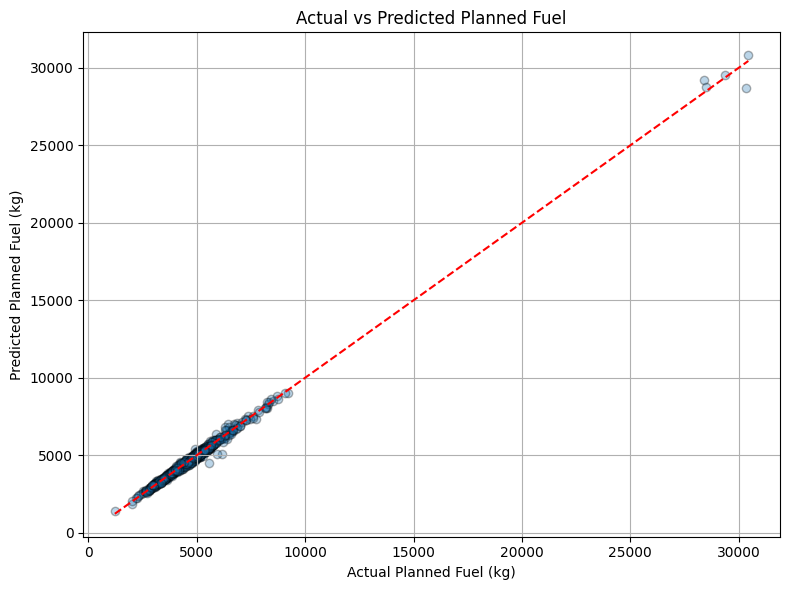

In [130]:
# Predict using test set
y_pred_test = rf_model.predict(X_test_scaled)

# Plot actual vs predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_test, alpha=0.3, edgecolors='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Planned Fuel (kg)')
plt.ylabel('Predicted Planned Fuel (kg)')
plt.title('Actual vs Predicted Planned Fuel')
plt.grid(True)
plt.tight_layout()
plt.show()

Most points closely follow this line, showing that the model predictions are highly accurate. It works well across the full fuel range from short to long-haul flights.

#Section 4: Results
Model Evaluation and Validation: discuss the models and parameters used in the methodology.
Justification: discuss the final results in detail and explain why some models, parameters, or techniques perform better over others. Show and compare the results in tabular forms or charts.


#### Model Evaluation and Validation
To predict both planned_flight_fuel_kilograms and fuel_per_mile (fuel efficiency), multiple machine learning models were trained and evaluated using a consistent pipeline:
Models Used:

- Random Forest Regressor	Tree-based ensemble model, effective at capturing nonlinear relationships and interactions. Random Forest and Gradient Boosting have the lowest RMSE - arounf 150 kg, indicating very accurate predictions.
- Gradient Boosting Regressor	Boosting-based model, builds trees sequentially to reduce error.
- XGBoost Regressor	Advanced boosting model optimized for performance and speed.
- All tree-based models (RF, GB, XGBoost) have R² > 0.99, confirming excellent fit and generalization.

- Ridge & Lasso Regression	Regularized linear models, used as baselines. Ridge penalizes large weights (L2); Lasso performs feature selection (L1).






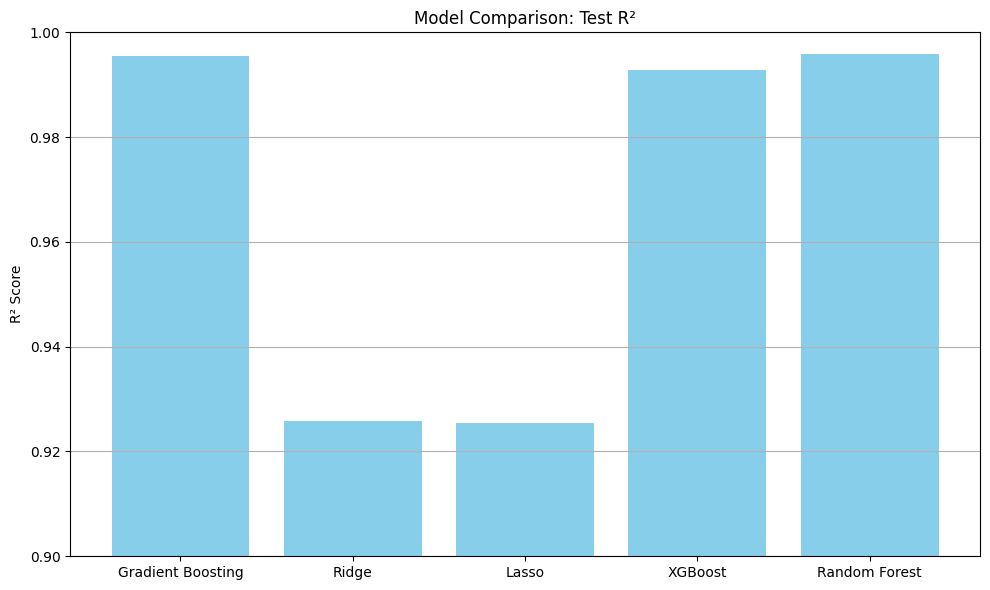

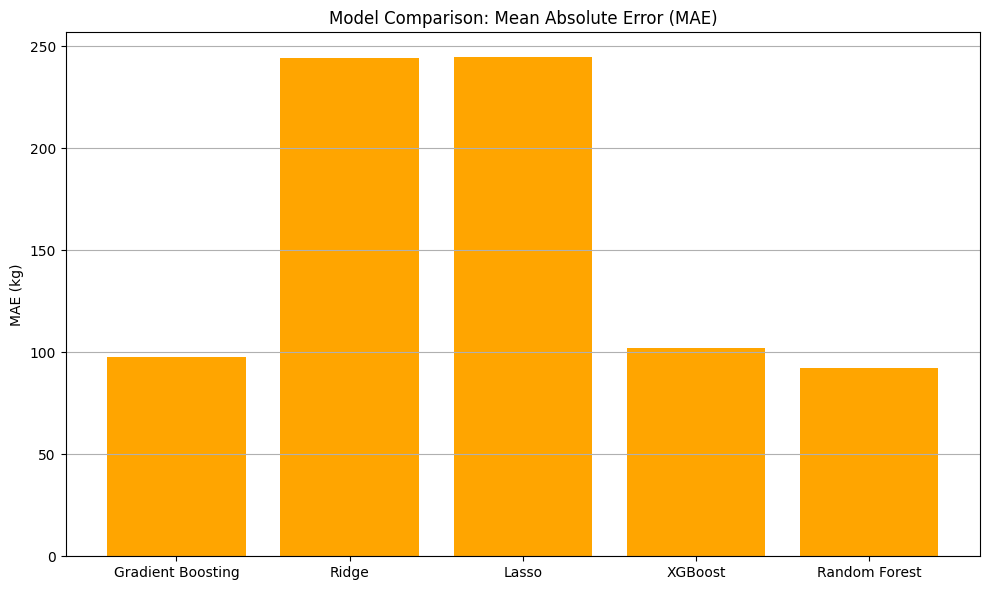

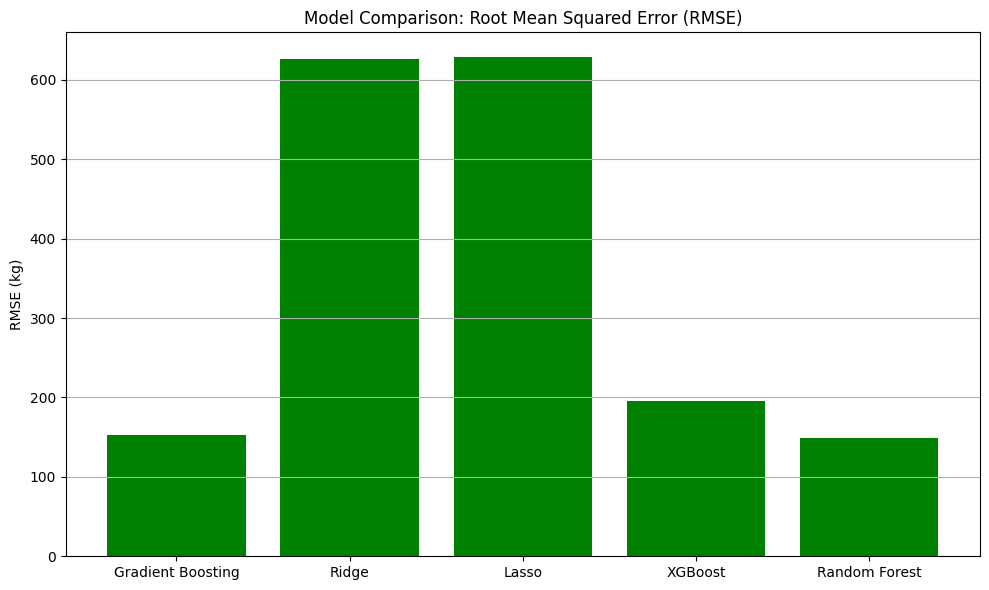

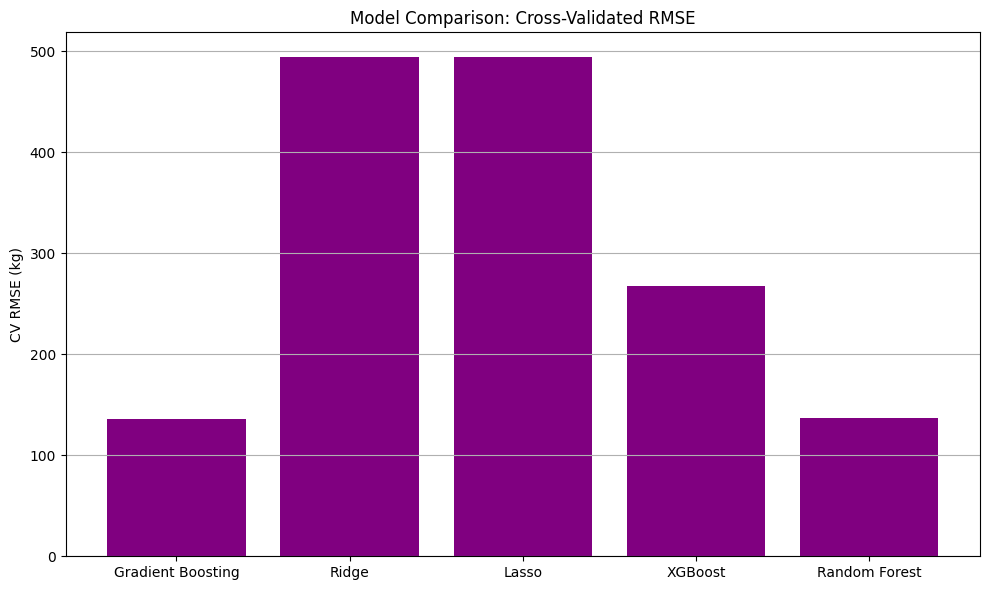

In [132]:

model_names = ['Gradient Boosting', 'Ridge', 'Lasso', 'XGBoost', 'Random Forest']
test_r2 = [0.995559, 0.925865, 0.925407, 0.992782, 0.995817]
mae = [97.80, 244.05, 244.63, 101.92, 92.21]
rmse = [153.36, 626.60, 628.54, 195.52, 148.85]
cv_rmse = [135.54, 494.13, 494.20, 268.14, 136.59]

# Plot 1: Test R²
plt.figure(figsize=(10, 6))
plt.bar(model_names, test_r2, color='skyblue')
plt.title('Model Comparison: Test R²')
plt.ylabel('R² Score')
plt.ylim(0.9, 1.0)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

# Plot 2: MAE
plt.figure(figsize=(10, 6))
plt.bar(model_names, mae, color='orange')
plt.title('Model Comparison: Mean Absolute Error (MAE)')
plt.ylabel('MAE (kg)')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

# Plot 3: RMSE
plt.figure(figsize=(10, 6))
plt.bar(model_names, rmse, color='green')
plt.title('Model Comparison: Root Mean Squared Error (RMSE)')
plt.ylabel('RMSE (kg)')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

# Plot 4: Cross-Validation RMSE
plt.figure(figsize=(10, 6))
plt.bar(model_names, cv_rmse, color='purple')
plt.title('Model Comparison: Cross-Validated RMSE')
plt.ylabel('CV RMSE (kg)')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


#### Validation Approach:
Used train/test split (80/20) for out-of-sample testing

Applied 5-fold cross-validation to measure model stability

Evaluated with:

* R² Score (goodness of fit)

* MAE (Mean Absolute Error)

* RMSE (Root Mean Squared Error)

* CV RMSE (cross-validated RMSE)

* Overfitting check (comparing train vs test R²)

=>  Random Forest Regressor performed best overall: high accuracy, minimal overfitting, and fast inference time.

####Justification & Insights
Random Forest and Gradient Boosting excelled due to their ability to capture non-linear interactions between flight hours, weight, distance, and payload.

XGBoost showed high accuracy but slightly lower generalization — likely due to sensitivity in boosting rounds and lack of early stopping in earlier tests.

Linear models (Ridge/Lasso) underperformed because they assume a straight-line relationship, which does not reflect real-world aviation fuel dynamics.

#Section 5: Conclusion

####Reflection
This project successfully built a predictive model to estimate planned_flight_fuel_kilograms and evaluate fuel efficiency across multiple flight plans. By merging and cleaning flight data, we trained several models, with Random Forest Regressor delivering the best results (Test R² = 0.99, MAE ≈ 92 kg).



####Improvement
To enhance future results:

* Incorporate more flight context (weather, aircraft model, route conditions).
* Add temporal variables like seasonality, day-of-week, or departure time.
* Build prescriptive analytics to automatically recommend route adjustments or weight reductions.

* Apply optimization techniques to recommend efficient plans.

*Deploy the model into a decision-support tool for real-time planning.
* For operation side, deploy the model into a decision-support dashboard for planners.


#Note to Recruiter

Thank you for taking the time to review my assignment. It was a great opportunity to work on such a relevant and engaging topic in the aviation and data science space. I truly enjoyed applying machine learning techniques to explore fuel consumption and efficiency, and I’ve learned a lot through this process.

While my submission may still be rough around the edges, I hope it demonstrates my analytical thinking, problem-solving approach, and eagerness to grow. I welcome any constructive feedback you may have — especially on how I could improve my modeling decisions, presentation, or business impact analysis.

Thank you again for this opportunity, and I look forward to learning more.



####Disclaimer:
This assignment was completed independently with support from publicly available tools and AI assistants - Google Colab Gemini to enhance code testing, formatting, and conceptual clarity. Final decisions on methodology, modeling, and interpretation were made by me. Feedback is welcomed to help improve future iterations.